In [1]:
# External imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats

# Internal imports

from pareto.analysis import time_sampled_psth, data_framing, calculate_fano, compute_fano_metrics

In [2]:
# Defining session

sessions = [1044385384]
areas_of_interest = ["VISp", "VISpm"]
conditions = ["active", "passive"]

# Defining local paths

ROOT_DIR = Path.cwd().parents[1]
DATA_DIR = ROOT_DIR / 'data'

In [17]:
def process_sessions(
    sessions: list, 
    ):

  out = {}

  for sid in sessions:

    o_path = DATA_DIR / 'onsets' / f"{sid}.csv"
    p_path = DATA_DIR / 'psths' / f"{sid}.npy"
    tp_path = DATA_DIR / 'tps' / "tps.npy"
    u_path = DATA_DIR / 'units' / f"{sid}.csv"
    vsel_path = DATA_DIR / 'wilcoxon_selectivity' / f"{sid}.csv"

    # Collecting preprocessed data

    onsets_table = pd.read_csv(o_path)
    psths = np.load(p_path)
    tps = np.load(tp_path)
    vsel = pd.read_csv(vsel_path)
    units = pd.read_csv(u_path)

    onsets_table = onsets_table[onsets_table["image_name"] != "omitted"]

    # Collecting time-sampled PSTH traces

    ts_psths, tpc, n_timesamples = time_sampled_psth(psths, tps, sample_window=50)

    # Arranging time-sampled PSTHs according to main data framings: session --> area --> condition --> either: imagewise or framewise

    df = data_framing(ts_psths, onsets_table, vsel, units)

    out[sid] = df

  return out, tpc, n_timesamples



In [18]:
data, tpc, n_timesamples = process_sessions(sessions)

In [19]:
def session_mv(
    data: dict,
):
  
  out = {}
  
  for sid, session in data.items():

    area_stats = {}

    for aid, area in session.items():

      pooled = {}
      fw_pooled = {}

      for cid, condition in area.items():

        if cid not in pooled:
          pooled[cid] = {"means": [], "variances": []}

        for _, arrs in condition['iw'].items():

          means = arrs.mean(axis=2)
          variances = arrs.var(axis=2)

          pooled[cid]["means"].append(means)
          pooled[cid]["variances"].append(variances)
        
        pooled[cid]["means"] = np.hstack(pooled[cid]["means"])
        pooled[cid]["variances"] = np.hstack(pooled[cid]["variances"])

        if cid not in fw_pooled:
          fw_pooled[cid] = {}

        for frame, img_arrs in condition['fw'].items():

          if frame not in fw_pooled[cid]:
            fw_pooled[cid][frame] = {"means": [], "variances": []}

          for _, arrs in img_arrs.items():

            means = arrs.mean(axis=2)
            variances = arrs.var(axis=2)

            fw_pooled[cid][frame]["means"].append(means)
            fw_pooled[cid][frame]["variances"].append(variances)
          
          fw_pooled[cid][frame]["means"] = np.hstack(fw_pooled[cid][frame]["means"])
          fw_pooled[cid][frame]["variances"] = np.hstack(fw_pooled[cid][frame]["variances"])
      
      area_stats[aid] = {
        "pooled": pooled,
        "fw_pooled": fw_pooled
      }
    
    out[sid] = area_stats
  
  return out

In [20]:
mv = session_mv(data)

In [21]:
def calculate_fano(
    data: dict
):
  
  out = {}
  
  for sid, session in data.items():
    
    area_fano = {}

    for aid, area in session.items():

      if aid not in area_fano:

        area_fano[aid] = {"pooled": {}, "fw_pooled": {}}

      for did, datastructure in area.items():
        
        if did == "pooled":

          for cid, condition in datastructure.items():

            if cid not in area_fano[aid][did]:
              area_fano[aid][did][cid] = []

            means = condition["means"]
            variances = condition["variances"]

            for ts in range(n_timesamples):
              
              m = means[ts,:]
              v = variances[ts,:]

              slope = stats.linregress(m,v)[0]
              area_fano[aid][did][cid].append(slope)
        
        else:

          for cid, condition in datastructure.items():
            
            if cid not in area_fano[aid][did]:
              area_fano[aid][did][cid] = {}

            for fid, frame in condition.items():

              if fid not in area_fano[aid][did][cid]:
                area_fano[aid][did][cid][fid] = []

              means = frame["means"]
              variances = frame["variances"]

              for ts in range(n_timesamples):

                m = means[ts,:]
                v = variances[ts,:]

                slope = stats.linregress(m,v)[0]

                area_fano[aid][did][cid][fid].append(slope)
                
    out[sid] = area_fano

  return out  

In [22]:
fano = calculate_fano(mv)

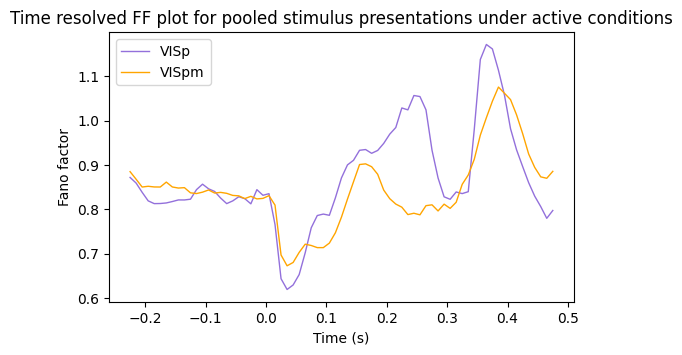

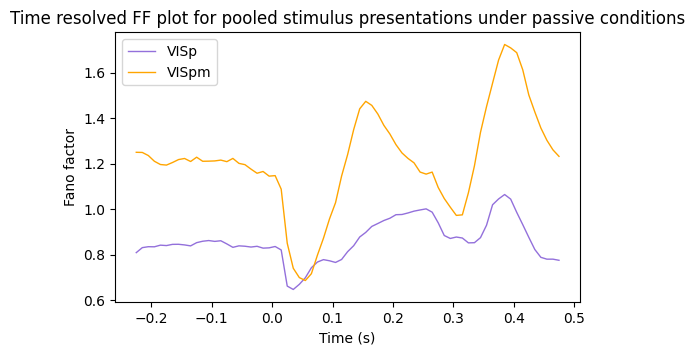

In [23]:
def plot_fano(
    data: dict,
    tpc: np.ndarray,
    data_structure: str,
    conditions: list,
    areas: list
  ):

  for sid, session in data.items():
    for c in conditions:
      
      fig, ax = plt.subplots(figsize=(6, 3.5))

      for a in areas:

        if a == "VISp":
          colour = 'mediumpurple'
        else:
          colour = 'orange'
        
        x = tpc 
        y = session[a][data_structure][c]

        ax.plot(x, y, color=colour, lw=1, label=a)
      
      ax.set_xlabel("Time (s)")
      ax.set_ylabel("Fano factor")
      ax.set_title(f"Time resolved FF plot for pooled stimulus presentations under {c} conditions")
      ax.legend()
  
  return fig, ax

fig, ax = plot_fano(fano, tpc, "pooled", ["active", "passive"], areas_of_interest)